### USX Clustering Techniques

In [1]:
%load_ext watermark

In [2]:
%watermark -a 'Durga' -v -d -p numpy,pandas,matplotlib,sklearn,seaborn

Durga 2017-01-11 

CPython 2.7.12
IPython 5.1.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.3
sklearn 0.18.1
seaborn 0.7.1


In [3]:
%matplotlib inline

# general libs
import sys
import numpy as np
import pandas as pd
import sklearn
import itertools

#plotting libs
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DayLocator, HourLocator, MinuteLocator, AutoDateLocator, DateFormatter

# date time libs
import datetime as dt
from datetime import timedelta
import statsmodels.api as sm 

# ml libs
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# CSS Fileb
from IPython.core.display import HTML
from IPython.display import Image

# Style Setting
sns.set(style="ticks", color_codes=True)
sns.set_context("notebook")
sns.set_style("darkgrid")

In [4]:
# Notebook Style Setting
css = open('styles/style-table.css').read() + open('styles/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [5]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code On/Off"></form>''')

### Overview

Say you are an admin with 100+ volumes and want to know succintly the capacity usage patterns on these volumes (or) high-low end groupings of your volumes (or) the usage relationships between your volumes. Otherwise, say your interest is not capacity usages but you want the above for latencies, throughputs etc.

There could be many reasons for this ranging from gaining better understanding to reducing workload by focusing on daily basis to a representative subset of volumes instead of entire environment.

This notebook contains the techniques to learn from data and do above utilizing various statistical & ML techinques. Specifics - Data cleanup, feature engineering, feature extraction using PCA, distortion minimization, k-means clustering & evaluation. Similarly it synthesizes correlation networks to quantify relationships.

### APIs...

In [6]:
##### DATA API ###########

def read_metric_data(csv_name):
    '''
        Read data from a given csv file.
        CSV format: [server_name, timestamp, value]
        Timestamp format: YYYY-MM-DD HH:mm:SS
        Lines begining with # are ignored as comments.
    '''
    # Read from csv file.
    df = pd.read_csv(csv_name, index_col=1, parse_dates=True, names=[ 'server', 'value'], comment='#', quotechar="'", sep=",")
    if(df.isnull().value.any()): 
        #print ("{0} - missing data row count#: {1}".format(csv_name, np.count_nonzero(df1.isnull().values)))
        df = df.fillna(method='ffill', limit=2) # Fill last value upto two consequtive slots
    print("{0} --- #(rows:columns): {1}".format(csv_name, df.shape))
    return df

def rename_series(series, prefix='v'):
    s = series.unique()
    newS = pd.Series(np.arange(len(s), dtype=np.int))
    newS = newS.apply(lambda x:  prefix + str(x))
    d = dict(zip(s, newS))
    newSeries =series.map(d)
    return newSeries

def expand_df(df, ef=2, freq='D'):
    d = df.copy()
    d1 = pd.concat([df]*ef, ignore_index=True)
    d1.index = pd.date_range(df.index[0], periods=len(d1), freq=freq)
    return d1

In [7]:
# Plot Clusters
def plot_clusters(g):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.set_palette(sns.color_palette("muted", 10))
    palette = itertools.cycle(sns.color_palette())
    for name, group in g:
        count = group.server.count()
        area = count*1500
        label = "C:{0}\n({1})".format(name, count)
        plt.scatter(name, group.server.count(), s=area, color=next(palette), marker='o', alpha=0.7)
        ax.annotate(label, (name*0.99, count), fontsize=10)
    plt.title("Clusters by similarity in capacity usage per day...")
    plt.xlabel("Cluster Name")
    plt.ylabel("Cluster Size")
    plt.tight_layout()
    plt.show()

### Data Load & Data Preprocessing

In [8]:
# Read capacity used metric
df_used1 = read_metric_data("data/capacity/kelsey-capused-d.txt")

# revise server values
df_used1.server = rename_series(df_used1.server, prefix="v")

# Preprocess Data
df_used1.loc[:,('value')] = (df_used1.value/(1024*1024*1024)).round(2)

data = df_used1.copy()
data['timestamp'] = data.index
data = data.pivot(index='timestamp', columns='server', values='value')
data = data.dropna(axis=1)

n_samples, n_features = data.shape
print("Data: \nn_samples: %d, \t n_features: %d \nfeatures (nodes): %s"% (n_samples, n_features, data.columns.values))

data/capacity/kelsey-capused-d.txt --- #(rows:columns): (4156, 2)
Data: 
n_samples: 42, 	 n_features: 64 
features (nodes): ['v0' 'v1' 'v11' 'v14' 'v15' 'v16' 'v17' 'v19' 'v2' 'v20' 'v22' 'v23' 'v25'
 'v27' 'v28' 'v29' 'v3' 'v30' 'v31' 'v33' 'v36' 'v38' 'v39' 'v40' 'v42'
 'v43' 'v46' 'v49' 'v50' 'v52' 'v53' 'v54' 'v57' 'v58' 'v6' 'v60' 'v61'
 'v62' 'v63' 'v65' 'v67' 'v68' 'v69' 'v7' 'v71' 'v72' 'v73' 'v74' 'v76'
 'v77' 'v78' 'v79' 'v8' 'v80' 'v81' 'v82' 'v84' 'v89' 'v9' 'v90' 'v91'
 'v93' 'v95' 'v96']


In [9]:
# Compute capacity percentage usage per day
dataset = data.copy()
dataset = dataset.pct_change()*100
dataset = dataset.fillna(method='bfill')
#dataset.tail()

#### Summary stats...

In [10]:
print("Daily capacity usage % summary across all servers...")
summary = dataset.describe()
summary = summary.drop("count", axis=0)
summary = summary.round(2)
summary

Daily capacity usage % summary across all servers...


server,v0,v1,v11,v14,v15,v16,v17,v19,v2,v20,...,v81,v82,v84,v89,v9,v90,v91,v93,v95,v96
mean,8.80,0.80,1.76,0.00,-0.03,0.02,-0.09,0.04,-0.20,1.64,...,1.94,0.0,1.53,0.23,1.62,1.79,1.75,1.63,2.00,0.09
std,28.50,6.31,10.76,2.80,2.80,2.72,2.48,2.75,2.29,11.32,...,3.52,0.0,11.51,9.50,11.44,11.44,12.25,11.87,11.88,2.17
min,-20.68,-13.79,-21.50,-8.85,-6.71,-6.36,-5.88,-5.77,-10.81,-27.99,...,-2.05,0.0,-23.10,-47.19,-24.04,-21.24,-21.49,-20.96,-25.22,-7.04
25%,-2.22,-2.24,-5.43,-1.21,-1.48,-1.39,-1.16,-1.47,-0.73,-4.53,...,0.00,0.0,-4.75,-1.21,-3.50,-5.45,-3.78,-4.20,-3.05,-0.24
50%,2.13,0.46,0.00,-0.03,0.00,-0.08,0.05,-0.35,-0.08,2.45,...,0.61,0.0,1.96,-0.03,0.16,2.58,1.84,2.15,3.17,0.04
75%,10.60,4.61,10.28,1.96,1.45,1.03,1.12,1.57,0.50,9.21,...,2.39,0.0,10.26,1.62,9.88,8.41,10.94,11.17,12.13,0.58
max,138.03,13.26,23.21,5.26,5.96,7.61,6.90,5.88,4.34,19.32,...,18.99,0.0,26.53,29.12,24.41,24.49,29.38,21.37,20.47,7.90


stats summary map... note: look for dark colors in each row


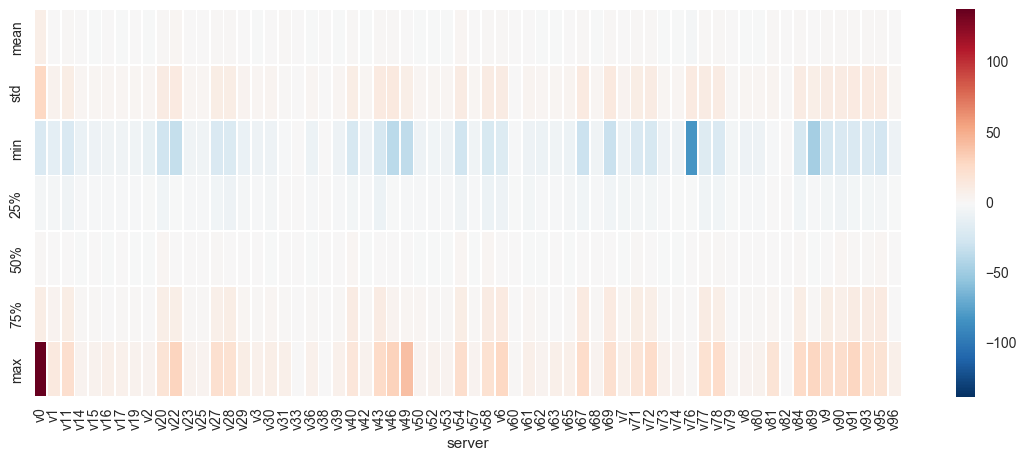

In [11]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 5))
sns.heatmap(summary, linewidths=.5)
print("stats summary map... note: look for dark colors in each row")

### Feature Engineering & Extraction

Performing dimensionality reduction via feature extraction...
Performing max clusters identification via distortion minimization...


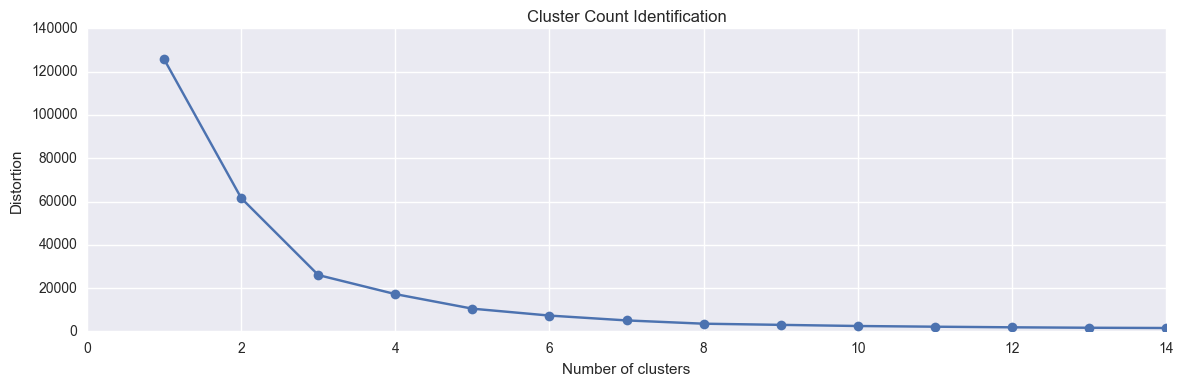

In [12]:
print("Performing dimensionality reduction via feature extraction...")
pca = PCA(n_components=5)
reduced_data = pca.fit_transform(dataset.T.values)

print("Performing max clusters identification via distortion minimization...")
max_clusters=15
distortions = []
for i in range(1, max_clusters):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=20, 
                max_iter=300, 
                random_state=0)
    km.fit(reduced_data)
    distortions.append(km.inertia_)

fig = plt.figure(figsize=(12, 4))
plt.plot(range(1, max_clusters), distortions, marker='o')
plt.title("Cluster Count Identification")
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
#plt.savefig('./figures/elbow.png', dpi=300)
plt.show()

### Cluster Modelling

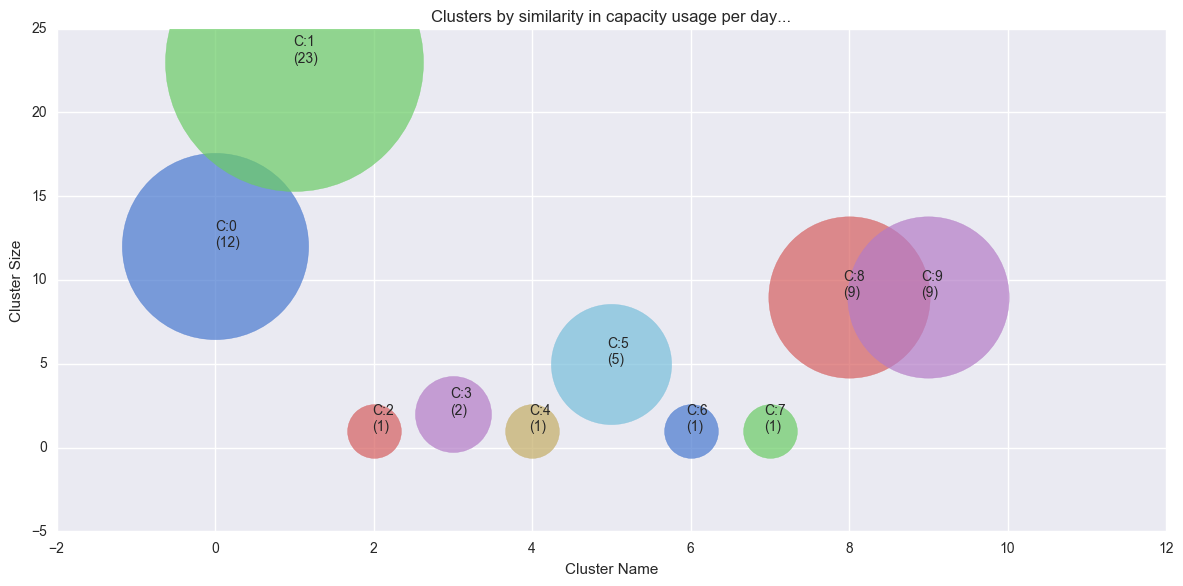

Cluster:0, Servers:['v40' 'v43' 'v54' 'v69' 'v71' 'v72' 'v84' 'v9' 'v90' 'v91' 'v93' 'v95']
Cluster:1, Servers:['v1' 'v14' 'v15' 'v16' 'v17' 'v19' 'v23' 'v25' 'v3' 'v31' 'v36' 'v39'
 'v42' 'v50' 'v52' 'v53' 'v57' 'v62' 'v68' 'v73' 'v74' 'v8' 'v80']
Cluster:2, Servers:['v0']
Cluster:3, Servers:['v22' 'v46']
Cluster:4, Servers:['v76']
Cluster:5, Servers:['v29' 'v30' 'v61' 'v65' 'v7']
Cluster:6, Servers:['v89']
Cluster:7, Servers:['v49']
Cluster:8, Servers:['v11' 'v20' 'v27' 'v28' 'v58' 'v6' 'v67' 'v77' 'v78']
Cluster:9, Servers:['v2' 'v33' 'v38' 'v60' 'v63' 'v79' 'v81' 'v82' 'v96']


In [13]:
# Reduce Dimensions
pca = PCA(n_components=5)
reduced_data = pca.fit_transform(dataset.T.values)

# Do K-Means
km = KMeans(n_clusters=10, 
            init='k-means++', 
            n_init=20, 
            max_iter=300, 
            random_state=0)
km.fit(reduced_data)

# Identify Clusters
clusters = pd.DataFrame.from_dict(zip(km.labels_, dataset.columns), orient='columns')
clusters.columns=["cluster", "server"]
g1 = clusters.groupby('cluster')

# Plot Clusters
plot_clusters(g1)

# Print Clusters
for name, group in g1:
    print("Cluster:%s, Servers:%s"%(name, group['server'].values))

### Correlation networks...

In [14]:
## Compute correlation matrix
corr_df = dataset.corr()
corr_matrix = corr_df.values
names = corr_df.columns.values

## Remove weak correlations to construct a graph
threshold = 0.7
corr_matrix[np.where(abs(corr_matrix) < threshold)] = 0

Correlations summary on daily capacity usage between nodes...
note: Look for blue colors...those nodes are negatively correlated.


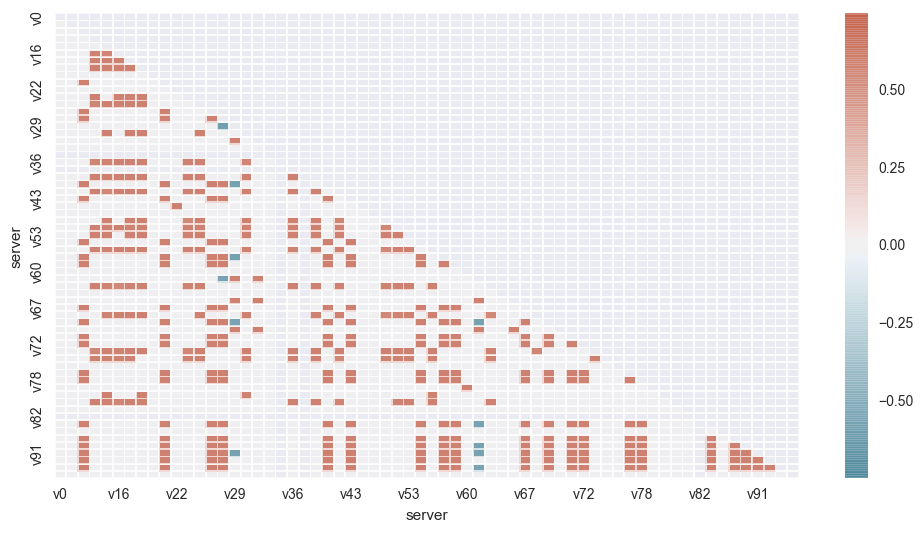

In [15]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, alpha=0.7,
            xticklabels=5, yticklabels=5,
            linewidths=.5, ax=ax)
print("Correlations summary on daily capacity usage between nodes...")
print("note: Look for blue colors...those nodes are negatively correlated.")

In [16]:
# Constructing a graph
import networkx as nx
import pylab
import random as rn

G = nx.Graph(corr_matrix)
nodes, edges = G.order(), G.size()

## Explore graph properties
print("Generating Network... nodes:{0}, edges:{1}, avg_degree:{2}".format(nodes, edges, edges/float(nodes)))

## Count degrees
degrees = G.degree()
values = sorted(set(degrees.values()))
counts = [degrees.values().count(x) for x in values]

Generating Network... nodes:64, edges:655, avg_degree:10.234375


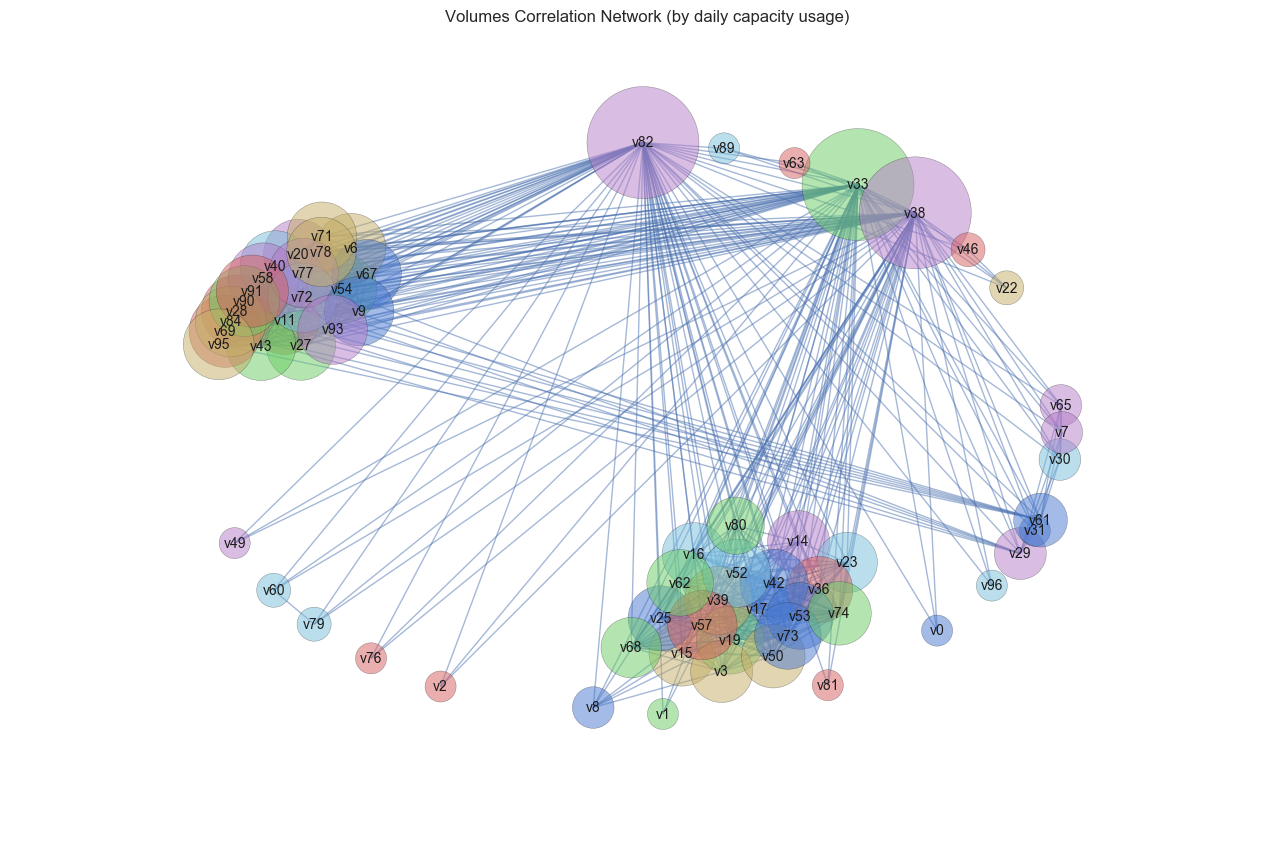

*circle size = number of nodes correlated with.


In [17]:
fig  = plt.figure(figsize=(12, 8))
sns.set_palette(sns.color_palette("muted", 40))
palette = itertools.cycle(sns.color_palette())
nx.draw(G, pos=nx.spring_layout(G, iterations=100), font_size=10,
        alpha=0.5, edge_color='b', with_labels=True, 
        node_color=sns.color_palette(),
        node_size=[v * 100 for v in degrees.values()],
        labels = dict(zip(range(len(names)), names))
       )
plt.title("Volumes Correlation Network (by daily capacity usage)")
plt.show()

print("*circle size = number of nodes correlated with.")